# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable


## Introduction
Describe how you framed the challenge by telling us what problem are you trying to solve and how your solution solves that problem.

## Development

In [12]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

In [2]:
# O ficheiro é demasiado grande para o github
df = pd.read_csv('/home/ana/Downloads/parking-tickets-2017-2019_WDL.csv', sep=';', index_col=0,
                 parse_dates=['EntryDate'])
df

/home/ana/anaconda3/envs/data_analysis/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Block,Street,EntryDate,Bylaw,Section,Status,InfractionText,Year,HBLOCK
0,1400,Kingsway,2017-08-23,2849,17.1,IS,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2017,1400 KINGSWAY
1,2100,13th Ave E.,2017-08-26,2849,19.1(H),IS,STOP ON EITHER SIDE OF A LANE WHICH ABUTS COMM...,2017,2100 13TH AVE E
2,2800,Trinity St.,2017-08-26,2849,17.6(B),VA,PARK ON A STREET WHERE A TRAFFIC SIGN RESTRICT...,2017,2800 TRINITY ST
3,200,17th Ave W.,2017-08-27,2849,17.5(B),IS,STOP WITHIN 6 METRES OF THE NEAREST EDGE OF TH...,2017,200 17TH AVE W
4,1900,4th Ave W.,2017-08-19,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,1900 4TH AVE W
...,...,...,...,...,...,...,...,...,...
1318730,1000,Smithe St.,2017-04-23,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,1000 SMITHE ST
1318731,2500,Yew St.,2017-04-24,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,2500 YEW ST
1318732,600,Seymour St.,2017-04-20,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,600 SEYMOUR ST
1318733,1300,Robson St.,2017-04-22,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,1300 ROBSON ST


In [3]:
def eda_to_df(df):
    header="+" + ("-"*52) + "+"
    form = "+{:^16s}|{:^16s}|{:^10s}|{:^7s}|"
    print(header)
    print(form.format("Column", "Type", "Uniques", "NaN?"))
    print(header)
    for col in df.columns:
        print(form.format(str(col), str(df[col].dtypes), str(len(df[col].unique())), 
                          str(df[col].isnull().values.any()) ))
    print(header)
eda_to_df(df)

+----------------------------------------------------+
+     Column     |      Type      | Uniques  | NaN?  |
+----------------------------------------------------+
+     Block      |     int64      |   129    | False |
+     Street     |     object     |   1785   | False |
+   EntryDate    | datetime64[ns] |   1089   | False |
+     Bylaw      |     int64      |    5     | False |
+    Section     |     object     |    98    | False |
+     Status     |     object     |    5     | False |
+ InfractionText |     object     |   123    | False |
+      Year      |     int64      |    3     | False |
+     HBLOCK     |     object     |  15219   | False |
+----------------------------------------------------+


## Categorical features

In [13]:
def categorical_feature_study(_df, feature, horizontal=False, treshould=0):
    df = _df.copy()
    df = df[feature].value_counts().to_frame()
    
    if treshould>0 :
        df = df[ df[feature] >= treshould ]
    
    df = df.reset_index()
    df = df.rename(columns={feature: "Count"})
    df = df.rename(columns={"index": feature})
    
    fig, ax = pyplot.subplots()#figsize=(20,15))
    
    if horizontal :
        sns.barplot(x="Count", y=feature, data=df, ax=ax)
    else:
        sns.barplot(x=feature, y="Count", data=df, ax=ax)
        
    ax.plot()
    
    return df

,InfractionText,Count
0,PARK IN A METERED SPACE IF THE PARKING METER H...,649308
1,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,144750
2,PARK ON A STREET WHERE A TRAFFIC SIGN RESTRICT...,106396
3,PARK ON ANY PORTION OF A STREET FOR A LONGER P...,70446
4,STOP WITHIN 6 METRES OF THE NEAREST EDGE OF TH...,42980


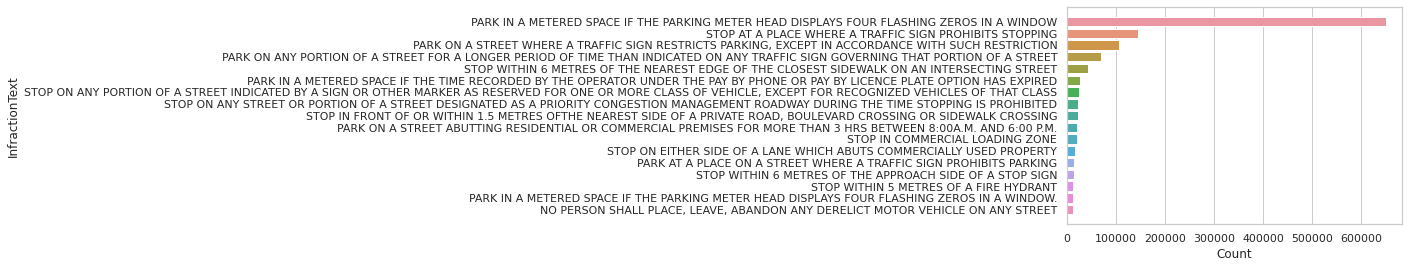

In [14]:
categorical_feature_study(df, "InfractionText", horizontal=True, treshould=10000).head()

,Year,Count
0,2018,456287
1,2019,434387
2,2017,428061


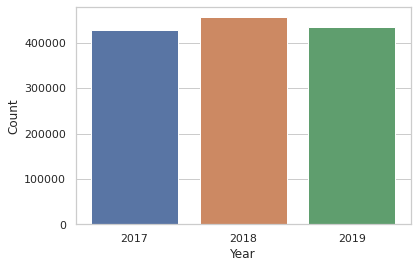

In [15]:
categorical_feature_study(df, "Year", horizontal=False)

,Bylaw,Count
0,2952,690170
1,2849,625978
2,9978,966
3,12086,909
4,9344,712


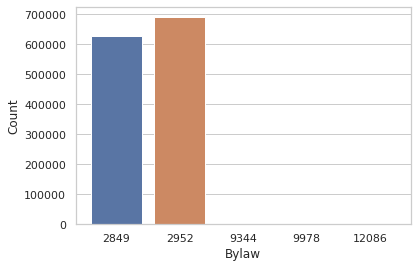

In [16]:
categorical_feature_study(df, "Bylaw", horizontal=False)

,HBLOCK,Count
0,1100 ALBERNI ST,9860
1,800 RICHARDS ST,8805
2,800 HOMER ST,7381
3,1000 ROBSON ST,7154
4,1000 HOMER ST,7076


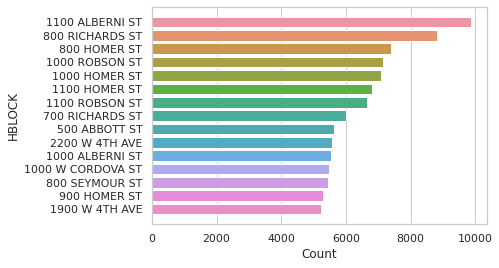

In [17]:
categorical_feature_study(df, "HBLOCK", horizontal=True, treshould=5000).head()

## Encode categorical features

In [19]:
enc = OrdinalEncoder()
df["InfractionText"] = enc.fit_transform(df[["InfractionText"]])

df

,Block,Street,EntryDate,Bylaw,Section,Status,InfractionText,Year,HBLOCK
0,1400,Kingsway,2017-08-23,2849,17.1,IS,37.0,2017,1400 KINGSWAY
1,2100,13th Ave E.,2017-08-26,2849,19.1(H),IS,63.0,2017,2100 13TH AVE E
2,2800,Trinity St.,2017-08-26,2849,17.6(B),VA,28.0,2017,2800 TRINITY ST
3,200,17th Ave W.,2017-08-27,2849,17.5(B),IS,91.0,2017,200 17TH AVE W
4,1900,4th Ave W.,2017-08-19,2952,5(4)(a)(ii),IS,21.0,2017,1900 4TH AVE W
...,...,...,...,...,...,...,...,...,...
1318730,1000,Smithe St.,2017-04-23,2952,5(4)(a)(ii),IS,21.0,2017,1000 SMITHE ST
1318731,2500,Yew St.,2017-04-24,2952,5(4)(a)(ii),IS,21.0,2017,2500 YEW ST
1318732,600,Seymour St.,2017-04-20,2952,5(4)(a)(ii),IS,21.0,2017,600 SEYMOUR ST
1318733,1300,Robson St.,2017-04-22,2952,5(4)(a)(ii),IS,21.0,2017,1300 ROBSON ST


## Conclusions

### Scalability and Impact
Tell us how applicable and scalable your solution is if you were to implement it in a city. Identify possible limitations and measure the potential social impact of your solution.

### Future Work
Now picture the following scenario: imagine you could have access to any type of data that could help you solve this challenge even better. What would that data be and how would it improve your solution? 🚀